In [1]:
from pattern import web
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

url = ["http://www.aishub.net/stations?page=" + str(i) for i in range(1, 16)]

def getTable(html):
    """
    Function
    --------
    Scans html for data table and returns as a dataframe.
    
    Parameters
    ----------
    html : URL address of data table
    
    Returns
    -------
    Full dataframe
    """
    
    #Nested functions
    def extractfromi(element):
        if '<i' in str(element):
            return web.Element(element)('i')[0].attrs['title']
        else:
            return element
        
    def extractfromspan(element):
        if '<span' in str(element):
            span = web.Element(element)('span')[0]
            if span.content == '': #Get tile
                return span.attrs['title']
            else:
                return span.content
        else:
            element
        
    def extractfroma(element):
        if '<a ' in str(element):
            a = web.Element(element)('a')[0]
            if a.content == '': #Get tile
                try:
                    return a.attrs['title']
                except:
                    return None
            else:
                return a.content
        else:
            return element
        
    
    #Extract all data from webpage
    u = web.URL(html)
    code = u.download(cached=True)
    dom = web.Element(code)
    
    #get list of headers of data columns
    table_header = dom('tr')[0]
    headers = [table_header('th a')[i].content for i in range(len(table_header('th a')))]
    headers.append('Source')
    
    #Define the result as a dataframe containing all named columns
    result = pd.DataFrame({k: [] for k in headers})
    
    #Get table data and append to dataframe
    table_data = dom('tbody tr')
    for i in range(len(table_data)):
        row = table_data[i]
        tds = row('td')
        cells = [tds[j].content for j in range(len(tds))]
        
        #Make table readable for user
        for k in range(len(cells)):
            if "<i " in str(cells[k]):
                cells[k] = extractfromi(cells[k])
            elif "<span" in str(cells[k]):
                cells[k] = extractfromspan(cells[k])
            elif "<a " in str(cells[k]):
                cells[k] = extractfroma(cells[k])
        
        result = result.append(pd.Series(cells, index=headers), ignore_index=True)
    
    return result

station_list = pd.DataFrame()
for u in url:
    station_list = station_list.append(getTable(u))
station_list = station_list.set_index('ID')

station_list

,Status,Uptime,Country,Location,Ships,Distinct,Source
ID,,,,,,,
2418,Online,100 %,Angola,Zaire,39,38,None
2766,Online,97 %,Angola,Zaire,9,9,None
2995,Online,100 %,Australia,Kingston,10,8,None
2502,Online,100 %,Australia,Scarborough,4,0,None
2508,Online,100 %,Australia,Port Stephens,27,10,None
2740,Online,100 %,Australia,Coogee,23,0,None
2556,Online,99 %,Australia,Franklin,5,5,None
2637,Online,91 %,Australia,Devonport,4,4,None
2936,Online,99 %,Australia,Kettering,14,12,None


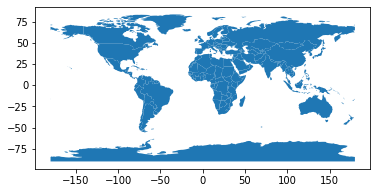

In [203]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={'name': 'Country'})

world = world.set_index('Country')
world.plot()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


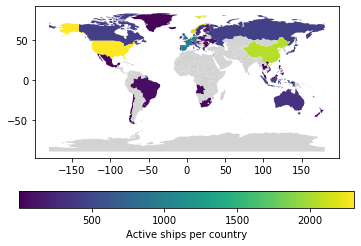

In [204]:
def mapByDistinct(stations):
    """
    Function
    --------
    Maps each country by how many of its distint ships are active
    
    Parameters
    ----------
    stations: dataframe of each station on record
    
    Returns
    -------
    Nothing
    """
    stations = stations[(stations.Status == "Online") & (stations.Country != 'Unknown')]
    stations.Country = stations.Country.replace("Viet Nam", "Vietnam").replace("Saint Martin (FR)", "France").replace("Taiwan (Province of China)", "Taiwan").replace("Russian Federation", "Russia")
    stations = stations.set_index(['Country','Source'])
    distinct_total = stations.Distinct.astype(int).sum(level="Country")
    
    #append to world
    global world
    world["Ship_circulation_est"] = distinct_total
    
    #plot result
    result = world.plot(column='Ship_circulation_est', 
                        legend=True,
                        legend_kwds={'label': 'Active ships per country',
                                     'orientation': 'horizontal'},
                        missing_kwds={'color':'lightgrey'})
    plt.savefig('shipsPerCountry.png')
    
    return result

ships_per_Country = mapByDistinct(station_list)

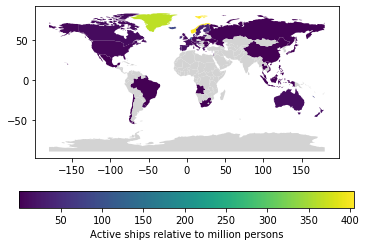

In [205]:
#Now less see the amount of active ships per 1000000 persons for each country
world["Ships_per_1e6"] = (world.Ship_circulation_est / world.pop_est) * 1e6


ships_per_1e6 = world.plot(column='Ships_per_1e6', 
                           legend=True,
                           legend_kwds={'label': 'Active ships relative to million persons',
                                        'orientation': 'horizontal'},
                           missing_kwds={'color': 'lightgray'})
plt.savefig('shipsPer1e6.png')


In [206]:
from scipy.special import erf
def GaussianProb():
    """
    Function
    --------
    Works out gaussian porobability that ship belongs to specific demographic. Adds to dataframe
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    """
    cdf = lambda x, mu, sig: 0.5 * (1 + erf((x - mu) / (sig * np.sqrt(2))))
    
    global world
    world["CDF"] = cdf(world.Ship_circulation_est, world.Ship_circulation_est.mean(), world.Ship_circulation_est.std())
    
    #If NaN assume zero
    world.CDF = world.CDF.fillna(float(0))
    
GaussianProb()

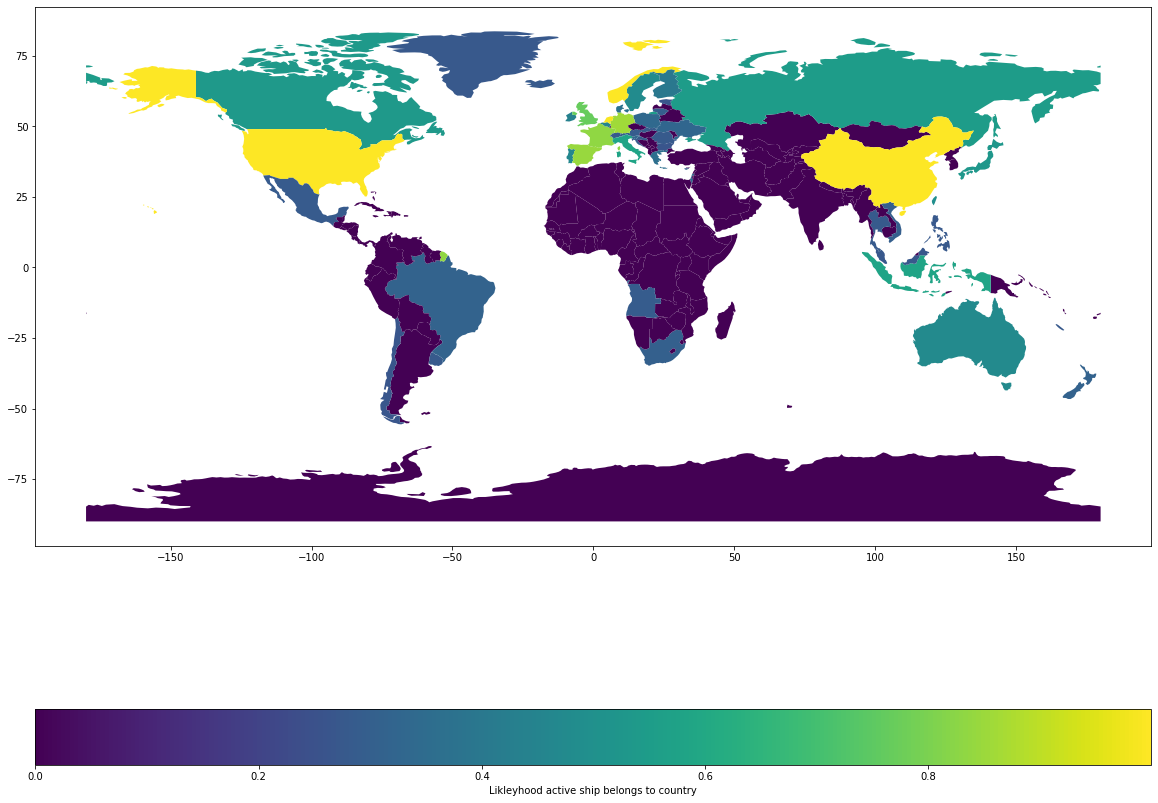

In [207]:
fig, ax = plt.subplots(figsize = (20, 20))
ships_cdf = world.plot(column='CDF', 
                           legend=True,
                           legend_kwds={'label': 'Likleyhood active ship belongs to country',
                                        'orientation': 'horizontal'},
                       ax=ax)
plt.savefig('shipsCDF.png')

In [7]:
ports = pd.DataFrame({'Country': station_list.Country, 'Location': station_list.Location}).drop_duplicates()

In [8]:
#We will have to find a way of adding geometric loction to each station
#First less add a column to ports labeled geometry and set each entry to None
ports["Longitude"] = [None for i in range(ports.shape[0])]
ports["Latitude"] = [None for i in range(ports.shape[0])]
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ports

,Country,Location,Longitude,Latitude
ID,,,,
2418,Angola,Zaire,None,None
2995,Australia,Kingston,None,None
2502,Australia,Scarborough,None,None
2508,Australia,Port Stephens,None,None
2740,Australia,Coogee,None,None
2556,Australia,Franklin,None,None
2637,Australia,Devonport,None,None
2936,Australia,Kettering,None,None
2465,Australia,Darwin,None,None


In [9]:
import wikipedia as wiki
def getGeometry(station):
    """
    Function
    --------
    Gets geometric location for each port, by mining wikipedia.
    
    Parameters
    ----------
    station: Entry in dataframe ports
    
    Returns
    -------
    geometry: estimated location in float form
    """
    coords = None
    i = 0
    engine = wiki.search(station.Location + ', ' + station.Country)
    while i < len(engine):
        try:
            page = wiki.page(engine[i])
            coords = page.coordinates
            break
        except wiki.exceptions.DisambiguationError as dmbError:
            engine = wiki.search(station.Location + ', ' + station.Country + ', port')
        except:
            coords = None
        i = i + 1
    
    try:
        station.Longitude = float(coords[0])
        station.Latitude = float(coords[1])
    except:
        station.Longitude = float(np.nan)
        station.Latitude = float(np.nan)
        
    return station

j = 0
while j < 586:
    ports.iloc[j, :] = getGeometry(ports.iloc[j, :])
    j = j + 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\ProgramData\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [10]:
ports

,Country,Location,Longitude,Latitude
ID,,,,
2418,Angola,Zaire,-6.26667,14.2333
2995,Australia,Kingston,-35.3156,149.144
2502,Australia,Scarborough,-31.8942,115.764
2508,Australia,Port Stephens,-32.75,151.917
2740,Australia,Coogee,-33.919,151.256
2556,Australia,Franklin,-43.1492,147.868
2637,Australia,Devonport,-41.1806,146.346
2936,Australia,Kettering,-43.1167,147.267
2465,Australia,Darwin,-12.4381,130.841


In [11]:
#Drop nan items from Dataframe
ports = ports.dropna()
ports

,Country,Location,Longitude,Latitude
ID,,,,
2418,Angola,Zaire,-6.26667,14.2333
2995,Australia,Kingston,-35.3156,149.144
2502,Australia,Scarborough,-31.8942,115.764
2508,Australia,Port Stephens,-32.75,151.917
2740,Australia,Coogee,-33.919,151.256
2556,Australia,Franklin,-43.1492,147.868
2637,Australia,Devonport,-41.1806,146.346
2936,Australia,Kettering,-43.1167,147.267
2465,Australia,Darwin,-12.4381,130.841


In [12]:
#Convert pors to geoDataFrame
geoPorts = gpd.GeoDataFrame(ports, geometry=gpd.points_from_xy(ports.Latitude, ports.Longitude))

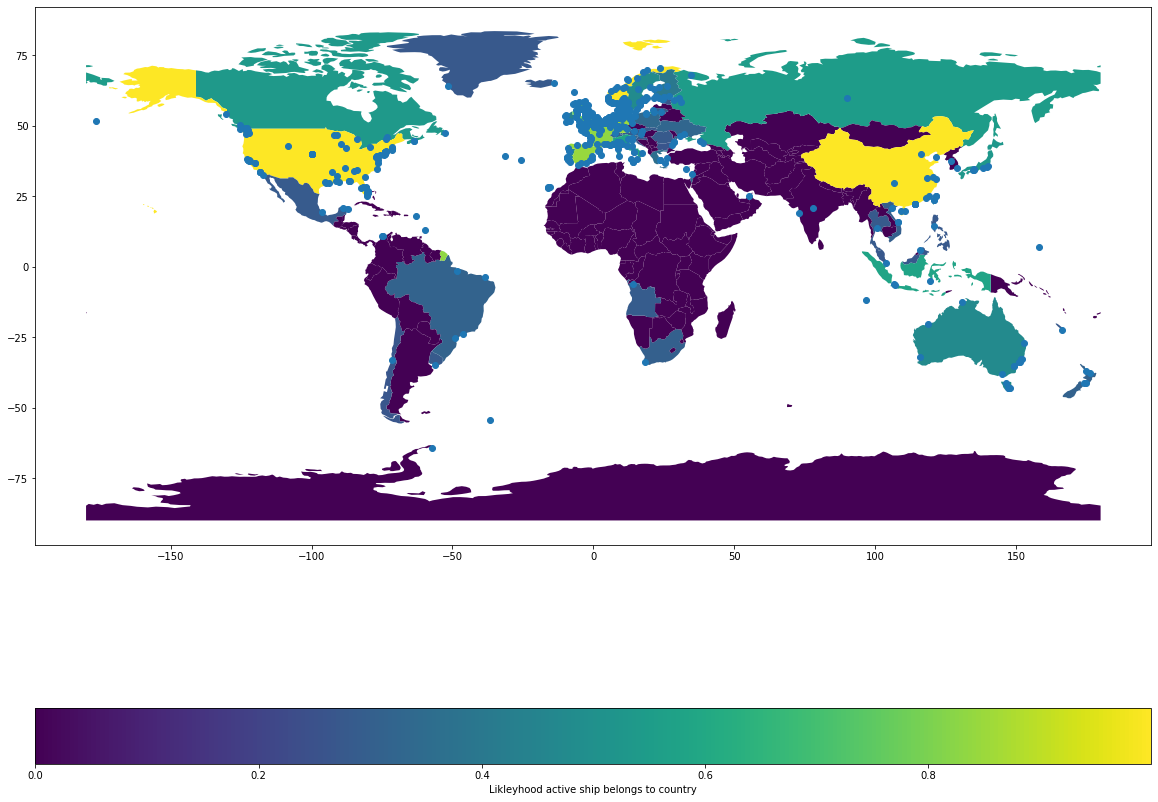

In [208]:
fig, ax = plt.subplots(figsize = (20, 20))
world.plot(column='CDF', 
           legend=True,
           legend_kwds={'label': 'Likleyhood active ship belongs to country',
                        'orientation': 'horizontal'},
           ax=ax)
geoPorts.plot(ax=ax)

In [14]:
def nearestStation(start, dest, location):
    """
    Function
    --------
    Function will take a coordinate pair, start 
    country and destination country, then return the nearest 
    station. Assume this is in the case of a lost and 
    stranded ship that is in need of finding its way back. We 
    will try to find this through checking the 2 norm.
    
    Parameters
    ----------
    start: Country the ship left
    dest: Country the ship wants to get to
    location: Coordinates of ship
    
    Returns
    -------
    Station: Location the ship needs to go to to get back on 
    course.
    """
    
    global world, geoPorts
    origin = world[world.index == start].geometry.bounds
    end = world[world.index == dest].geometry.bounds
    
    #Assume longest route to get vector direction in unit form
    vector = {'x': end.maxx[0] - origin.minx[0], 'y': end.maxy[0] - origin.miny[0]}
    vector = {'x': vector['x'] / np.sqrt(pow(vector['x'], 2) + pow(vector['y'], 2)), 
          'y': vector['y'] / np.sqrt(pow(vector['x'], 2) + pow(vector['y'], 2))}
    
    locV = {'x': location[0], 'y': location[0]}
    
    station = geoPorts.iloc[0, :]
    #First try and find if there are any stations between location and destination
    possibleStations = geoPorts[(geoPorts.Longitude > min(end.maxx[0], location[0])) & 
                                (geoPorts.Longitude < max(end.maxx[0], location[0])) &
                                (geoPorts.Latitude > min(end.maxy[0], location[0])) &
                                (geoPorts.Latitude < max(end.maxy[0], location[0]))]
    #If empty check any towards start point
    if possibleStations.shape[0] == 0:
        possibleStations = geoPorts[(geoPorts.Longitude > min(origin.maxx[0], location[0])) & 
                                    (geoPorts.Longitude < max(origin.maxx[0], location[0])) &
                                    (geoPorts.Latitude > min(origin.maxy[0], location[0])) &
                                    (geoPorts.Latitude < max(origin.maxy[0], location[0]))]
        if possibleStations.shape[0] == 0:
            possibleStations = geoPorts
            
    #Now get distance between each station and location
    possibleStations["distance"] = np.power(np.power(np.abs(possibleStations.Longitude - location[0]), 2) + 
                                           np.power(np.abs(possibleStations.Latitude - location[1]), 2), 1/2)
    
    ps = pd.DataFrame(possibleStations)
    
    #find entry with minimum distance and return
    station = ps[ps.distance == ps.distance.min()]
    
    script = "Please head towards " + str(station.Location[0]) + ", " + str(station.Country[0]) + ".\n In direction: Longitude = " + str(station.Longitude[0] - locV['x']) + ", Latitude = " + str(station.Latitude[0] - locV['y'])
    
    return station, script

In [15]:
nearestStation('Australia', 'Angola', (-50, 75))

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(     Country   Location Longitude Latitude                    geometry  \
 ID                                                                       
 2850  Brazil  Fortaleza   -3.7275 -38.5275  POINT (-38.52750 -3.72750)   
 
      distance  
 ID             
 2850  122.595  ,
 'Please head towards Fortaleza, Brazil.\n In direction: Longitude = 46.2725, Latitude = 11.472499999999997')

In [16]:
#Add a colour scheme to which one can recognise the status of each station
color = []
for s in geoPorts.Location:
    status = (station_list[station_list.Location == s]).Status.values[0]
    uptime = float(((station_list[station_list.Location == s]).Uptime.values[0]).strip('%')) / 100
    
    c = None
    if status == 'Online':
        c = (0, 1, uptime)
    elif status == 'Offline > 10 minutes':
        c = (1, 115/256, uptime)
    elif status == 'Offline > 24 hours':
        c = (1, 0, uptime)
    elif status == "Dead":
        c = (0, 0, uptime)
        
    color.append(c)

geoPorts["Status"] = color

In [17]:
geoPorts[geoPorts.Status != (0, 1, 1)]

,Country,Location,Longitude,Latitude,geometry,Status
ID,,,,,,
2556,Australia,Franklin,-43.1492,147.868,POINT (147.86750 -43.14917),"(0, 1, 0.99)"
2637,Australia,Devonport,-41.1806,146.346,POINT (146.34639 -41.18056),"(0, 1, 0.91)"
2936,Australia,Kettering,-43.1167,147.267,POINT (147.26667 -43.11667),"(0, 1, 0.99)"
2465,Australia,Darwin,-12.4381,130.841,POINT (130.84111 -12.43806),"(0, 1, 0.98)"
3292,Australia,"Oakleigh, Victoria",-37.913,145.102,POINT (145.10200 -37.91300),"(0, 1, 0.91)"
3258,Barbados,St. James,13.2167,-59.6167,POINT (-59.61667 13.21667),"(0, 1, 0.47)"
2713,Belgium,Leuven,50.8833,4.7,POINT (4.70000 50.88333),"(1, 0.44921875, 0.51)"
3359,Belgium,Schoten,51.25,4.5,POINT (4.50000 51.25000),"(0, 1, 0.89)"
2724,Belgium,Ghent,51.05,3.73333,POINT (3.73333 51.05000),"(0, 1, 0.95)"


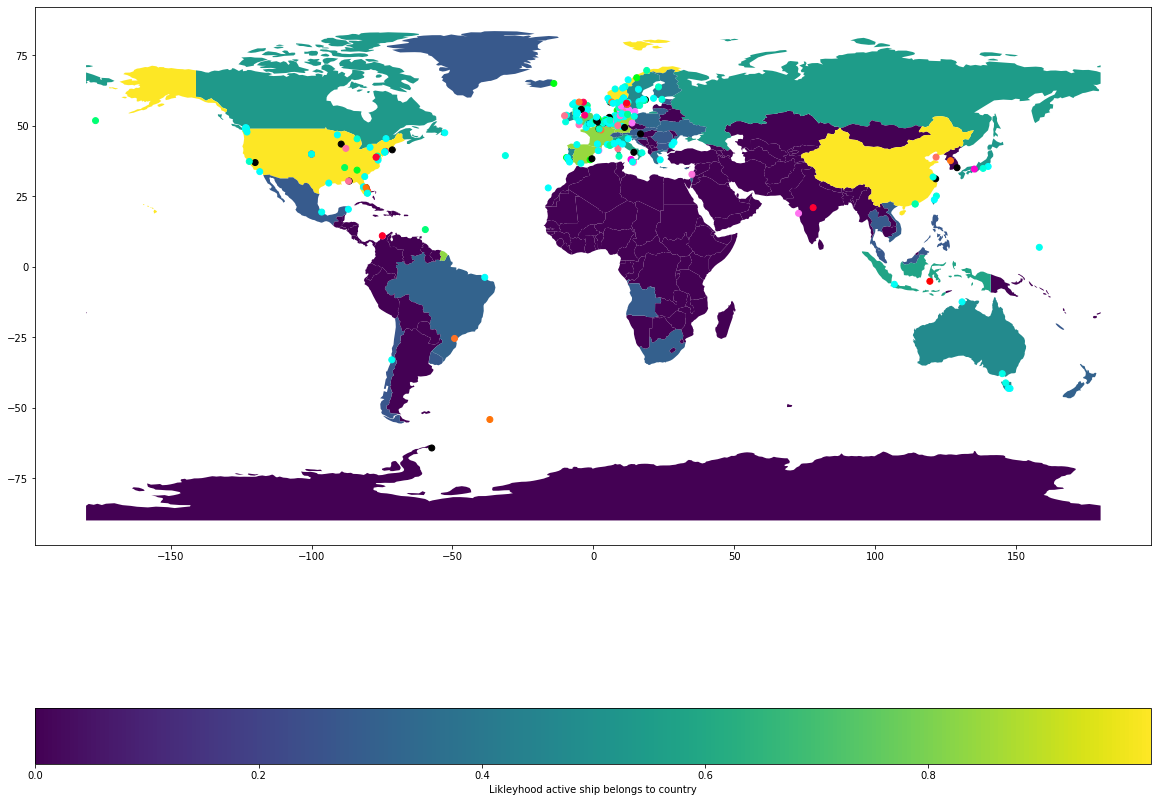

In [209]:
fig, ax = plt.subplots(figsize = (20, 20))
world.plot(column='CDF', 
           legend=True,
           legend_kwds={'label': 'Likleyhood active ship belongs to country',
                        'orientation': 'horizontal'},
           ax=ax)
geoPorts[geoPorts.Status != (0, 1, 1)].plot(color=geoPorts[geoPorts.Status != (0, 1, 1)]["Status"], legend=["Offline, Uptime < 100%"], ax=ax)

In [19]:
def nearestStationInOperation(start, dest, location):
    """
    Function
    --------
    Function will take a coordinate pair, start 
    country and destination country, then return the nearest 
    station. Assume this is in the case of a lost and 
    stranded ship that is in need of finding its way back. We 
    will try to find this through checking the 2 norm. This
    time we will exclude stations that are offline, below 100%
    uptime or dead.
    
    Parameters
    ----------
    start: Country the ship left
    dest: Country the ship wants to get to
    location: Coordinates of ship
    
    Returns
    -------
    Station: Location the ship needs to go to to get back on 
    course.
    """
    
    global world, geoPorts
    origin = world[world.index == start].geometry.bounds
    end = world[world.index == dest].geometry.bounds
    
    #Assume longest route to get vector direction in unit form
    vector = {'x': end.maxx[0] - origin.minx[0], 'y': end.maxy[0] - origin.miny[0]}
    vector = {'x': vector['x'] / np.sqrt(pow(vector['x'], 2) + pow(vector['y'], 2)), 
          'y': vector['y'] / np.sqrt(pow(vector['x'], 2) + pow(vector['y'], 2))}
    
    locV = {'x': location[0], 'y': location[0]}
    
    station = geoPorts[geoPorts.Status == (0, 1.0, 1.0)].iloc[0, :]
    #First try and find if there are any stations between location and destination
    possibleStations = geoPorts[(geoPorts.Longitude > min(end.maxx[0], location[0])) & 
                                (geoPorts.Longitude < max(end.maxx[0], location[0])) &
                                (geoPorts.Latitude > min(end.maxy[0], location[0])) &
                                (geoPorts.Latitude < max(end.maxy[0], location[0])) &
                                (geoPorts.Status == (0, 1.0, 1.0))]
    #If empty check any towards start point
    if possibleStations.shape[0] == 0:
        possibleStations = geoPorts[(geoPorts.Longitude > min(origin.maxx[0], location[0])) & 
                                    (geoPorts.Longitude < max(origin.maxx[0], location[0])) &
                                    (geoPorts.Latitude > min(origin.maxy[0], location[0])) &
                                    (geoPorts.Latitude < max(origin.maxy[0], location[0])) &
                                    (geoPorts.Status == (0, 1.0, 1.0))]
        if possibleStations.shape[0] == 0:
            possibleStations = geoPorts[geoPorts.Status == (0, 1.0, 1.0)]
            
    #Now get distance between each station and location
    possibleStations["distance"] = np.power(np.power(np.abs(possibleStations.Longitude - location[0]), 2) + 
                                           np.power(np.abs(possibleStations.Latitude - location[1]), 2), 1/2)
    
    ps = pd.DataFrame(possibleStations)
    
    #find entry with minimum distance and return
    station = ps[ps.distance == ps.distance.min()]
    
    script = "Please head towards " + str(station.Location[0]) + ", " + str(station.Country[0]) + ".\n In direction: Longitude = " + str(station.Longitude[0] - locV['x']) + ", Latitude = " + str(station.Latitude[0] - locV['y'])
    
    return station, script

In [20]:
nearestStationInOperation('Australia', 'Angola', (-50, 75))

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(     Country Location Longitude Latitude                     geometry  \
 ID                                                                      
 2024  Brazil   Santos  -23.9369  -46.325  POINT (-46.32500 -23.93694)   
 
            Status distance  
 ID                          
 2024  (0, 1, 1.0)  124.093  ,
 'Please head towards Santos, Brazil.\n In direction: Longitude = 26.06305556, Latitude = 3.674999999999997')

In [21]:
world[world.continent == 'Europe'].Ship_circulation_est.sum()

10784.0

In [22]:
#So less create a function that takes a series of rules
#based on known amount of ships in certain regions of 
#the world and predicts how many ships are in each 
#countries waters

#Expand geomtry and add as pairs of intervals to a new column called bounds
Bounds = world.geometry.bounds
world["bounds"] = [([Bounds.minx.iloc[c], Bounds.maxx.iloc[c]], [Bounds.miny.iloc[c], Bounds.maxy.iloc[c]]) for c in range(Bounds.shape[0])]
   
#Example rule function
def knowShipsNorthernHemisphere(N):
    global world
    north = world[world.bounds.minx >= 0]
    north.Ship_circulation_est = [0 for c in range(north.shape[0])]
    xsum = lambda x_: (N <= (north.CDF * x_).sum())
    return xsum

knowShipsNorthernHemisphere(50000)

<function __main__.knowShipsNorthernHemisphere.<locals>.<lambda>(x_)>

In [76]:
from scipy.optimize import linprog
def predictShipsPerCountry(Conditions_up, constraints_up, Conditions_eq=None, constraints_eq=None):
    """
    Function
    --------
    Calculates optimal prediction of ships per a country 
    using a set of conditions and constraints
    
    Parameters
    ----------
    Conditions: Set of conditions without contraints
                as matrix
                
    contraints: Vector of constraints
    
    Returns
    -------
    x_: array containing predicted ships for each country
    """
    global world
    c_ = np.array(-1 * world.CDF.values) #Assume maxization probems require the inverse of the minimise problem
    x_ = linprog(c_,
                 A_ub=Conditions_up,
                 b_ub=constraints_up,
                 A_eq=Conditions_eq,
                 b_eq=constraints_eq,
                 options={'maxiter': 100, 'disp': False, 'autoscale': False, 'presolve': False, 'rr': False, 'tol': 1.6e-11})
    return x_

In [77]:
#Now create a set of conditions and allocate a value for each one

#Assume that if each country has equal weight, 1, thae total ships in circulation is at most 100000
a0 = [1 for i in range(world.shape[0])]
b0 = 1e6

#Assume for every 1e9 $, a country can chose to have one ship
a1 = [1 * world.gdp_md_est.iloc[i] / 1e3 for i in range(world.shape[0])]
b1 = world.gdp_md_est.sum() / 1e3

#Assume for a every 1e6 people, a country must have one ship available
a2 = [-1 * world.pop_est.iloc[i] / 1e6 for i in range(world.shape[0])]
b2 = -7500

#Assume knowledge of number of ships around each continent
#Europe
a3 = [(1 if world.continent.iloc[i] == 'Europe' else 0) for i in range(world.shape[0])]
b3 = world.Ship_circulation_est[world.continent == 'Europe'].sum()

#North America
a4 = [(1 if world.continent.iloc[i] == 'North America' else 0) for i in range(world.shape[0])]
b4 = world.Ship_circulation_est[world.continent == 'North America'].sum()

#South America
a5 = [(1 if world.continent.iloc[i] == 'South America' else 0) for i in range(world.shape[0])]
b5 = world.Ship_circulation_est[world.continent == 'South America'].sum()

#Asia
a6 = [(1 if world.continent.iloc[i] == 'Asia' else 0) for i in range(world.shape[0])]
b6 = world.Ship_circulation_est[world.continent == 'Asia'].sum()

#Oceania
a7 = [(-1 if world.continent.iloc[i] == 'Oceania' else 0) for i in range(world.shape[0])]
b7 = world.Ship_circulation_est[world.continent == 'Oceania'].sum()

#Africa
a8 = [(1 if world.continent.iloc[i] == 'Africa' else 0) for i in range(world.shape[0])]
b8 = world.Ship_circulation_est[world.continent == 'Africa'].sum()

#Antarctica
a9 = [(1 if world.continent.iloc[i] == 'Antarctica' else 0) for i in range(world.shape[0])]
b9 = world.Ship_circulation_est[world.continent == 'Antarctica'].sum()

#Now put these rules into processible form for calculating the prediction
A_ub = np.array([a0, a1, a2]) 
A_eq = np.array([a3, a4, a5, a6, a7, a8, a9])
b_ub = np.array([b0, b1, b2]) 
b_eq = np.array([b3, b4, b5, b6, b7, b8, b9])

In [78]:
#Now calculate a prediction from the above rules
x_ = predictShipsPerCountry(A, b_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: OptimizeWarning: Unknown solver options: autoscale, rr


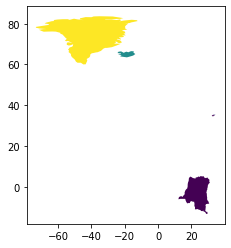

In [83]:
world["New_Ship_Est"] = x_.x
world[world.New_Ship_Est > 0].plot(column="New_Ship_Est")

#This definately did not produce the best prediction here. This is most likeyly the result of Greenland
#and Iceland having a disproportionate number of stataions for there population size.

In [90]:
#Create function to strip a substring from all elements in a series
def strip(series, sub):
    result = series
    for i in range(series.shape[0]):
        result.iloc[i] = series.values[i].strip(sub)
    return result

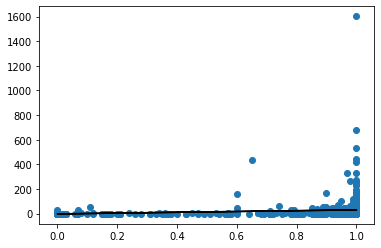

In [114]:
uptimeAsDecimal = strip(station_list.Uptime, '%').astype(float).values / 100
distinct = station_list.Distinct.values.astype(float)

m, b = np.polyfit(uptimeAsDecimal, distinct, 1)

#Plot Uptime by Distinct for each station 
plt.scatter(uptimeAsDecimal, distinct)
plt.plot(uptimeAsDecimal, m*uptimeAsDecimal+b, color='black')

#Evident outliers here

Text(0.5, 0, 'Likelyhood of ships')

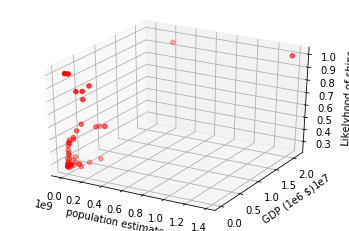

In [151]:
#Now look at the data per country, this might do well looking a plotting CDF against both pop_est and gdp_md_est
#Less take out countries where CDF = 0
from mpl_toolkits.mplot3d import Axes3D

hasShips = world[world.CDF > 0]

x = hasShips.pop_est.values.astype(float)
y = hasShips.gdp_md_est.values.astype(float)
z = hasShips.CDF.values.astype(float)

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

ax3d.scatter(xs=x, ys=y, zs=z, c='red')
ax3d.set_xlabel('population estimate')
ax3d.set_ylabel('GDP (1e6 $)')
ax3d.set_zlabel('Likelyhood of ships')

In [174]:
#There needs to be a method like numpy polyfit, but works this out for z = m * x + p * y + q
#This can be done with linear regression
from sklearn.linear_model import LinearRegression
X = np.array([[x[i], y[i]] for i in range(x.shape[0])])
reg = LinearRegression().fit(X, z)

xx = np.linspace(world.pop_est.min(), world.pop_est.max())
yy = np.linspace(world.gdp_md_est.min(), world.gdp_md_est.max())

zz = reg.coef_[0] * xx + reg.coef_[1] * yy + reg.intercept_

Text(0.5, 0, 'Likelyhood of ships')

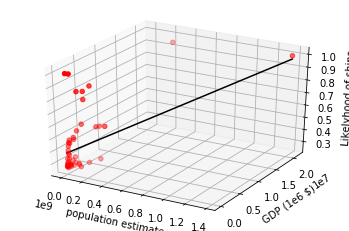

In [178]:
#Now less plot with result from linear regression
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

ax3d.scatter(xs=x, ys=y, zs=z, c='red')
ax3d.plot(xx, yy, zz, c='black')
ax3d.set_xlabel('population estimate')
ax3d.set_ylabel('GDP (1e6 $)')
ax3d.set_zlabel('Likelyhood of ships')

In [210]:
#Now for each country where cdf is zero as in unfound we shall estimate a new probability that they have ships
for i in range(world.shape[0]):
    if world.CDF.iloc[i] == 0:
        world.CDF.iloc[i] = reg.intercept_ + reg.coef_[0] * world.pop_est.iloc[i] + reg.coef_[1] * world.gdp_md_est.iloc[i]

world

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,pop_est,continent,iso_a3,gdp_md_est,geometry,Ship_circulation_est,Ships_per_1e6,CDF
Country,,,,,,,,
Fiji,920938,Oceania,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,0.382946
Tanzania,53950935,Africa,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,0.371972
W. Sahara,603253,Africa,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,0.382680
Canada,35623680,North America,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",417.0,11.705697,0.536780
United States of America,326625791,North America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",2306.0,7.060067,0.999670
Kazakhstan,18556698,Asia,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",NaN,NaN,0.399633
Uzbekistan,29748859,Asia,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",NaN,NaN,0.382836
Papua New Guinea,6909701,Oceania,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",NaN,NaN,0.381887
Indonesia,260580739,Asia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",485.0,1.861227,0.583793


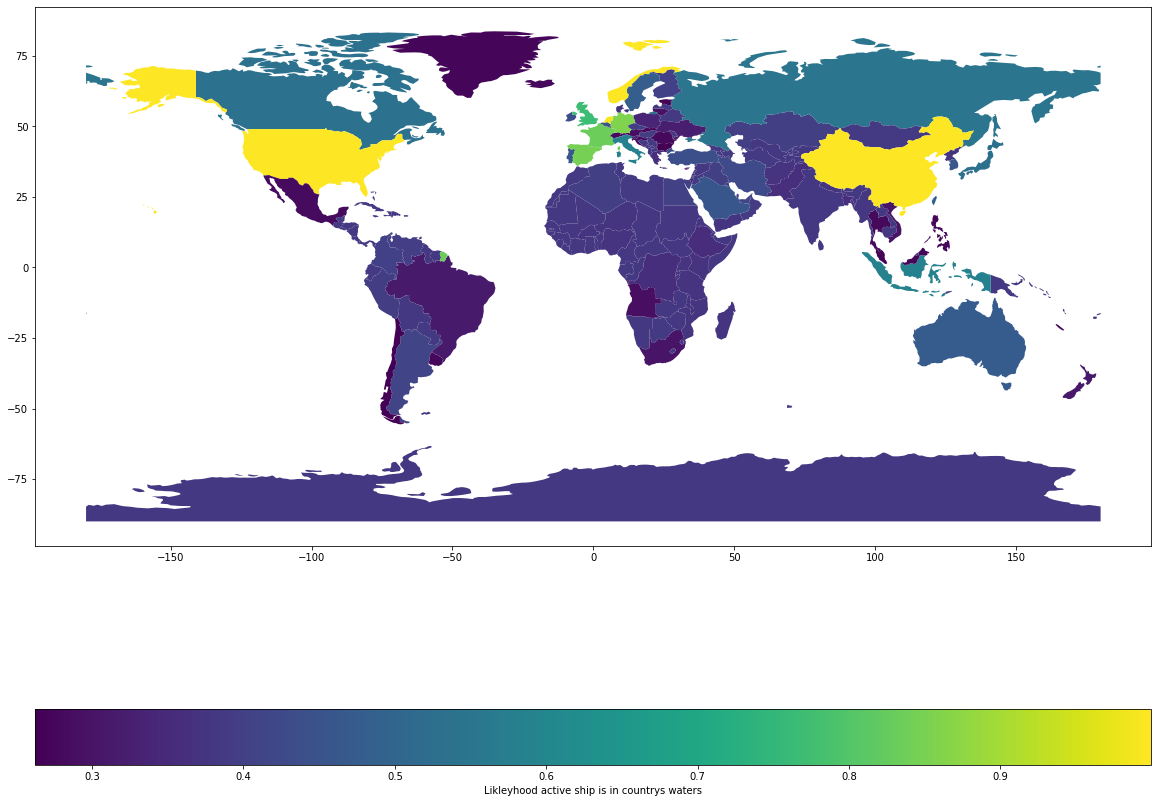

In [215]:
#Now plot
fig, ax = plt.subplots(figsize = (20, 20))
world.plot(column='CDF', 
           legend=True,
           legend_kwds={'label': 'Likleyhood active ship is in countrys waters',
                        'orientation': 'horizontal'},
           ax=ax)

In [223]:
#Now less use this with a biased random coin generator to predict where tomorrows ships are

import random as rnd
def biased_binary_generator(n_sim):
    """
    Function
    --------
    Runs a biased coin flip that a ship is either in the waters of a country or 
    not. This simulation is run n_sim times and works out a total.
    
    Parameters
    ----------
    n_sim: number of times to run simulation
    
    Returns
    -------
    None
    """
    
    global world
    
    flip = lambda p: 1 if rnd.random() >= p else 0 #Assume equal weight for each country
    
    world["New_Ship_Est"] = [np.array([flip(world.CDF.iloc[i]) for n in range(n_sim)]) for i in range(world.shape[0])]

In [ ]:
#Consider each country has a single radar post and can see only one ship
#at a time. These tick every s, 100000 times, where s is an arbitrary
#length of time
biased_binary_generator(100000)
world